In [2]:
%reload_ext dotenv
%dotenv
config_file_path='./config-dataunion-mumbai.ini'

In [3]:
import ocean_lib
import sys
import time
import os
from ocean_lib.config import Config
from ocean_lib.ocean.ocean import Ocean
from datetime import datetime
from IPython import display
from base64 import b64decode
from ocean_lib.web3_internal.currency import to_wei
from ocean_lib.web3_internal.wallet import Wallet
from ocean_lib.data_provider.data_service_provider import DataServiceProvider
from ocean_lib.services.service import Service
from ocean_lib.common.agreements.service_types import ServiceTypes
from ocean_lib.assets.trusted_algorithms import add_publisher_trusted_algorithm

print(f"Using python:{sys.version}")
print(f"Using ocean_lib: {ocean_lib.__version__}")

Using python:3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
Using ocean_lib: 0.8.5


# 1. Create ocean instance

In [4]:
config = Config(config_file_path)
ocean = Ocean(config)
provider_url = DataServiceProvider.get_url(ocean.config)

print(f"config.network_url = '{config.network_url}'")
print(f"config.block_confirmations = {config.block_confirmations.value}")
print(f"config.metadata_cache_uri = '{config.metadata_cache_uri}'")
print(f"config.provider_url = '{config.provider_url}'")

# Create Alice's wallet
alice_wallet = Wallet(
    ocean.web3,
    os.getenv('PRIVATE_KEY1'),
    config.block_confirmations,
    config.transaction_timeout,
)
print(f"alice_wallet.address = '{alice_wallet.address}'")

config.network_url = 'https://rpc-mumbai.maticvigil.com'
config.block_confirmations = 1
config.metadata_cache_uri = 'https://aquarius.dataunion.market'
config.provider_url = 'https://provider.dev.dataunion.market/'
alice_wallet.address = '0xdF1dEc52e602020E27B0644Ea0F584b6Eb5CE4eA'


# 2. Publish asset

In [5]:
# Publish DATA datatoken, mint tokens
DATA_datatoken = ocean.create_data_token('DATA1', 'DATA1', alice_wallet, blob=ocean.config.metadata_cache_uri)
DATA_datatoken.mint(alice_wallet.address, to_wei(100), alice_wallet)
print(f"DATA_datatoken.address = '{DATA_datatoken.address}'")

# Specify metadata & service attributes for Branin test dataset.
# It's specified using _local_ DDO metadata format; Aquarius will convert it to remote
# by removing `url` and adding `encryptedFiles` field.
DATA_metadata = {
    "main": {
        "type": "dataset",
        "files": [{
        # "url": "https://crab.dev.dataunion.app/api/v1/compute",
        "url": "https://raw.githubusercontent.com/trentmc/branin/main/branin.arff",
        "index": 0,
        "contentType": "text/text",
      }],
    "name": "branin", "author": "Dataunion", "license": "CC0",
    "dateCreated": "2019-12-28T10:55:11Z"
    }
}
DATA_service_attributes = {
    "main": {
        "name": "Dataunion_data_asset",
        "creator": alice_wallet.address,
        "timeout": 3600 * 24,
        "datePublished": "2019-12-28T10:55:11Z",
        "cost": 1.0, # <don't change, this is obsolete>
        }
}

# Set up a service provider. We'll use this same provider for ALG

# Calc DATA service compute descriptor

DATA_compute_service = Service(
    service_endpoint=provider_url,
    service_type=ServiceTypes.CLOUD_COMPUTE,
    attributes=DATA_service_attributes
)

DATA_access_service = Service(
    service_endpoint=provider_url,
    service_type=ServiceTypes.ASSET_ACCESS,
    attributes=DATA_service_attributes,
)

# Publish metadata and service info on-chain
DATA_ddo = ocean.assets.create(
  metadata=DATA_metadata, # {"main" : {"type" : "dataset", ..}, ..}
  publisher_wallet=alice_wallet,
  services=[DATA_compute_service, DATA_access_service],
  data_token_address=DATA_datatoken.address)
print(f"DATA did = '{DATA_ddo.did}'")

DATA_datatoken.address = '0x9F73a7B897425F741D3c88B2d15B1a4A85CCa256'
signing message with nonce 18: 0x9F73a7B897425F741D3c88B2d15B1a4A85CCa256, account=0xdF1dEc52e602020E27B0644Ea0F584b6Eb5CE4eA
DATA did = 'did:op:9F73a7B897425F741D3c88B2d15B1a4A85CCa256'


# 3. Publish algorithm

In [6]:
# Publish ALG datatoken
ALG_datatoken = ocean.create_data_token('ALG1', 'ALG1', alice_wallet, blob=ocean.config.metadata_cache_uri)
ALG_datatoken.mint(alice_wallet.address, to_wei(100), alice_wallet)
print(f"ALG_datatoken.address = '{ALG_datatoken.address}'")

# Specify metadata and service attributes, for "GPR" algorithm script.
# In same location as Branin test dataset. GPR = Gaussian Process Regression.
ALG_metadata =  {
    "main": {
        "type": "algorithm",
        "algorithm": {
            "language": "python",
            "format": "docker-image",
            "version": "0.1",
            "container": {
        #       "entrypoint": "python $ALGO",
        #       "image": "oceanprotocol/algo_dockers",
        #                                 "tag": "python-branin"
        #    "entrypoint": "python /app/algorithm.py",
         #   "image": "registry.dataunion.app/dataunion-vqgan",
         #   "tag": "latest"
       "entrypoint": "python /app/algorithm.py",
         "image": "registry.dataunion.app/vqgan-imagenet",
          "tag": "0.0.1"
            }
        },
        "files": [
      {
       # "url": "https://crab.dev.dataunion.app/api/v1/metadata/compute",
        "url": "https://crab.dev.dataunion.app/api/v1/compute",
        "index": 0,
        "contentType": "text/text",
      }
    ],
    "name": "gpr", "author": "Trent", "license": "CC0",
    "dateCreated": "2020-01-28T10:55:11Z"
    }
}
ALG_service_attributes = {
        "main": {
            "name": "ALG_dataAsset",
            "creator": alice_wallet.address,
            "timeout": 60*10,
            "datePublished": "2020-01-28T10:55:11Z",
            "cost": 1.0, # <don't change, this is obsolete>
        }
    }

# Calc ALG service access descriptor. We use the same service provider as DATA
ALG_access_service = Service(
    service_endpoint=provider_url,
    service_type=ServiceTypes.CLOUD_COMPUTE,
    attributes=ALG_service_attributes
)

# Publish metadata and service info on-chain
ALG_ddo = ocean.assets.create(
  metadata=ALG_metadata, # {"main" : {"type" : "algorithm", ..}, ..}
  publisher_wallet=alice_wallet,
  services=[ALG_access_service],
  data_token_address=ALG_datatoken.address)
print(f"ALG did = '{ALG_ddo.did}'")

ALG_datatoken.address = '0x49Ac32f39487ed08A6d4404f5706380deC49a25F'
signing message with nonce 19: 0x49Ac32f39487ed08A6d4404f5706380deC49a25F, account=0xdF1dEc52e602020E27B0644Ea0F584b6Eb5CE4eA
ALG did = 'did:op:49Ac32f39487ed08A6d4404f5706380deC49a25F'


# 4. Alice allows the algorithm for C2D for that data asset

In [7]:
time.sleep(30) # wait until Aquarius caches the asset  
add_publisher_trusted_algorithm(DATA_ddo, ALG_ddo.did, config.metadata_cache_uri)
ocean.assets.update(DATA_ddo, publisher_wallet=alice_wallet)

'0xed94ca8f43158054f5dbd707e2a794da815ad10dbab496dc47775919a1228ef0'

# 5. Bob acquires datatokens for data and algorithm

In [8]:
bob_wallet = Wallet(
    ocean.web3,
    os.getenv('PRIVATE_KEY2'),
    config.block_confirmations,
    config.transaction_timeout,
)
print(f"bob_wallet.address = '{bob_wallet.address}'")

# Alice shares access for both to Bob, as datatokens. Alternatively, Bob might have bought these in a market.
DATA_datatoken.transfer(bob_wallet.address, to_wei(50), from_wallet=alice_wallet)
ALG_datatoken.transfer(bob_wallet.address, to_wei(50), from_wallet=alice_wallet)

bob_wallet.address = '0x7F6470a7b08Bf4dfb3Ebd9330C5B3D594B1d5BB9'


'0x8f71f3c85934819653b75975f58f9a7bacc4233baae66949c69c59decc577968'

# 6. Bob starts a compute job

In [28]:
DATA_did = DATA_ddo.did  # for convenience
ALG_did = ALG_ddo.did
DATA_DDO = ocean.assets.resolve(DATA_did)  # make sure we operate on the updated and indexed metadata_cache_uri versions
ALG_DDO = ocean.assets.resolve(ALG_did)

compute_service = DATA_DDO.get_service('compute')
algo_service = ALG_DDO.get_service('access')

from ocean_lib.web3_internal.constants import ZERO_ADDRESS
from ocean_lib.models.compute_input import ComputeInput

# order & pay for dataset
dataset_order_requirements = ocean.assets.order(
    DATA_did, bob_wallet.address, service_type=compute_service.type
)
DATA_order_tx_id = ocean.assets.pay_for_service(
        ocean.web3,
        dataset_order_requirements.amount,
        dataset_order_requirements.data_token_address,
        DATA_did,
        compute_service.index,
        ZERO_ADDRESS,
        bob_wallet,
        dataset_order_requirements.computeAddress,
    )

# order & pay for algo
algo_order_requirements = ocean.assets.order(
    ALG_did, bob_wallet.address, service_type=algo_service.type
)
ALG_order_tx_id = ocean.assets.pay_for_service(
        ocean.web3,
        algo_order_requirements.amount,
        algo_order_requirements.data_token_address,
        ALG_did,
        algo_service.index,
        ZERO_ADDRESS,
        bob_wallet,
        algo_order_requirements.computeAddress,
)

custom_data = {
    'id': 'TdQovMPnnWPtvKE'
}

'''
Here:
{
    "id": "TdQovMPnnWPtvKE",
    "parameters": {
        "prompts": [
            "small | blue | claw"
        ]
    }
}
'''

compute_inputs = [ComputeInput(DATA_did, DATA_order_tx_id, compute_service.index)]
job_id = ocean.compute.start(
    compute_inputs,
    bob_wallet,
    algorithm_did=ALG_did,
    algorithm_tx_id=ALG_order_tx_id,
    algorithm_data_token=ALG_datatoken.address,
    algouserdata=custom_data
)
print(f"Started compute job with id: {job_id}")

Started compute job with id: 950c1bed999340d58b9d06f5eadaaa20


# 7. Get output

In [29]:
ocean.compute.status(DATA_did, job_id, bob_wallet)

{'ok': True, 'status': 70, 'statusText': 'Job finished'}

In [30]:
result = ocean.compute.result_file(DATA_did, job_id, 1, bob_wallet)  # 0 index, means we retrieve the results from the first dataset index

In [31]:
base64_data = ocean.compute.result_file(DATA_did, job_id, 0, bob_wallet)  # 0 index, means we retrieve the results from the first dataset index

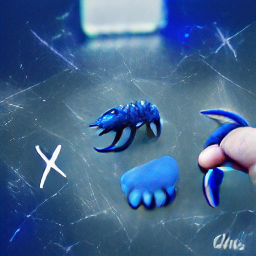

In [32]:
display.Image(b64decode(base64_data))